In [6]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from pandas import Timestamp
warnings.filterwarnings("ignore")


import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc 
import plotly.express as px
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)


rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# df = pd.read_csv('df.csv')

# dfIavg_A = df[['Time','Iavg_A']]

# def hourly_time(df):
#     # Convert the "Time" column to datetime format
#     df['Time'] = pd.to_datetime(df['Time'])
    
#     df.sort_values(by='Time', inplace=True)

#     # Set the "Time" column as the index
#     df.set_index('Time', inplace=True)

#     # Resample the DataFrame on an hourly basis and take the average of "Iavg_A"
#     hourly_df = df.resample('H').mean()

#     # Reset the index to include the hourly timestamps
#     hourly_df.reset_index(inplace=True)

#     return hourly_df


# dfIavg_A_Hourly = hourly_time(dfIavg_A)
# dfIavg_A_Hourly

In [10]:
# # import pandas as pd
# df = pd.read_csv('df.csv')

# dfIavg_A = df[['Time','Iavg_A']]


# def thirty_minute_interval(df):
#     # Convert the "Time" column to datetime format
#     df['Time'] = pd.to_datetime(df['Time'])
#     df.sort_values(by='Time', inplace=True)
    

#     # Set the "Time" column as the index
#     df.set_index('Time', inplace=True)

#     # Resample the DataFrame on a 30-minute basis and take the average of "Iavg_A"
#     interval_df = df.resample('30T').mean()

#     # Reset the index to include the 30-minute timestamps
#     interval_df.reset_index(inplace=True)

#     return interval_df

# dfIavg_A_30T = thirty_minute_interval(dfIavg_A)
# dfIavg_A_30T

In [11]:
dfIavg_A_30T = pd.read_csv('/dfIavg_A_30T.csv')
dfIavg_A_30T

,Time,Iavg_A
0,2021-01-02 19:00:00,16.633875
1,2021-01-02 19:30:00,16.423667
2,2021-01-02 20:00:00,16.329233
3,2021-01-02 20:30:00,15.975133
4,2021-01-02 21:00:00,16.658467
...,...,...
1331,2021-01-30 12:30:00,17.987600
1332,2021-01-30 13:00:00,18.071833
1333,2021-01-30 13:30:00,18.225000
1334,2021-01-30 14:00:00,18.387700


In [12]:
dfIavg_A_30T['Iavg_A'].fillna(dfIavg_A_30T.Iavg_A.mean(), inplace=True)

In [13]:
dfIavg_A_30T['Iavg_A'].min()

6.9883

In [14]:
# dfdfIavg_A_30T_I = dfIavg_A_30T.set_index('Time')
# plt.plot(dfIavg_A_30T_30T_I, label='Iavg_A')
# plt.legend();

In [15]:
import plotly.express as px


dfIavg_A_30T['Time'] = pd.to_datetime(dfIavg_A_30T['Time'])

# Use iplot to visualize the data
fig = px.line(dfIavg_A_30T, x='Time', y='Iavg_A', title='Iavg_A over Time')
fig.show()

Standard Scaling

In [16]:
train_size = int(len(dfIavg_A_30T) * 0.95)
test_size = len(dfIavg_A_30T) - train_size
train, test = dfIavg_A_30T.iloc[0:train_size], dfIavg_A_30T.iloc[train_size:len(dfIavg_A_30T)]
print(train.shape, test.shape)


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Iavg_A']])

train['Iavg_A'] = scaler.transform(train[['Iavg_A']])
test['Iavg_A'] = scaler.transform(test[['Iavg_A']])
     
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['Iavg_A']], train.Iavg_A, TIME_STEPS)
X_test, y_test = create_dataset(test[['Iavg_A']], test.Iavg_A, TIME_STEPS)

print(X_train.shape)
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')




history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)

(1269, 2) (67, 2)
(1239, 30, 1)
Epoch 1/10
6/6 [==============================] - 11s 1s/step - loss: 0.8311 - val_loss: 0.9794
Epoch 2/10
6/6 [==============================] - 4s 676ms/step - loss: 0.7448 - val_loss: 1.0064
Epoch 3/10
6/6 [==============================] - 3s 547ms/step - loss: 0.7198 - val_loss: 0.9383
Epoch 4/10
6/6 [==============================] - 4s 598ms/step - loss: 0.7045 - val_loss: 0.9774
Epoch 5/10
6/6 [==============================] - 4s 668ms/step - loss: 0.7052 - val_loss: 0.9402
Epoch 6/10
6/6 [==============================] - 4s 677ms/step - loss: 0.6948 - val_loss: 0.9595
Epoch 7/10
6/6 [==============================] - 3s 519ms/step - loss: 0.6946 - val_loss: 0.9555
Epoch 8/10
6/6 [==============================] - 3s 571ms/step - loss: 0.6956 - val_loss: 0.9579
Epoch 9/10
6/6 [==============================] - 3s 598ms/step - loss: 0.6895 - val_loss: 0.9514
Epoch 10/10
6/6 [==============================] - 5s 816ms/step - loss: 0.6942 - val_lo

In [17]:
# y_hat = model.predict(X_test)
# y_hat.reshape(-1,30)
# y_hat.shape

# model.evaluate(X_test,y_test)

PLOT THE LOSS VS ECPOCHS

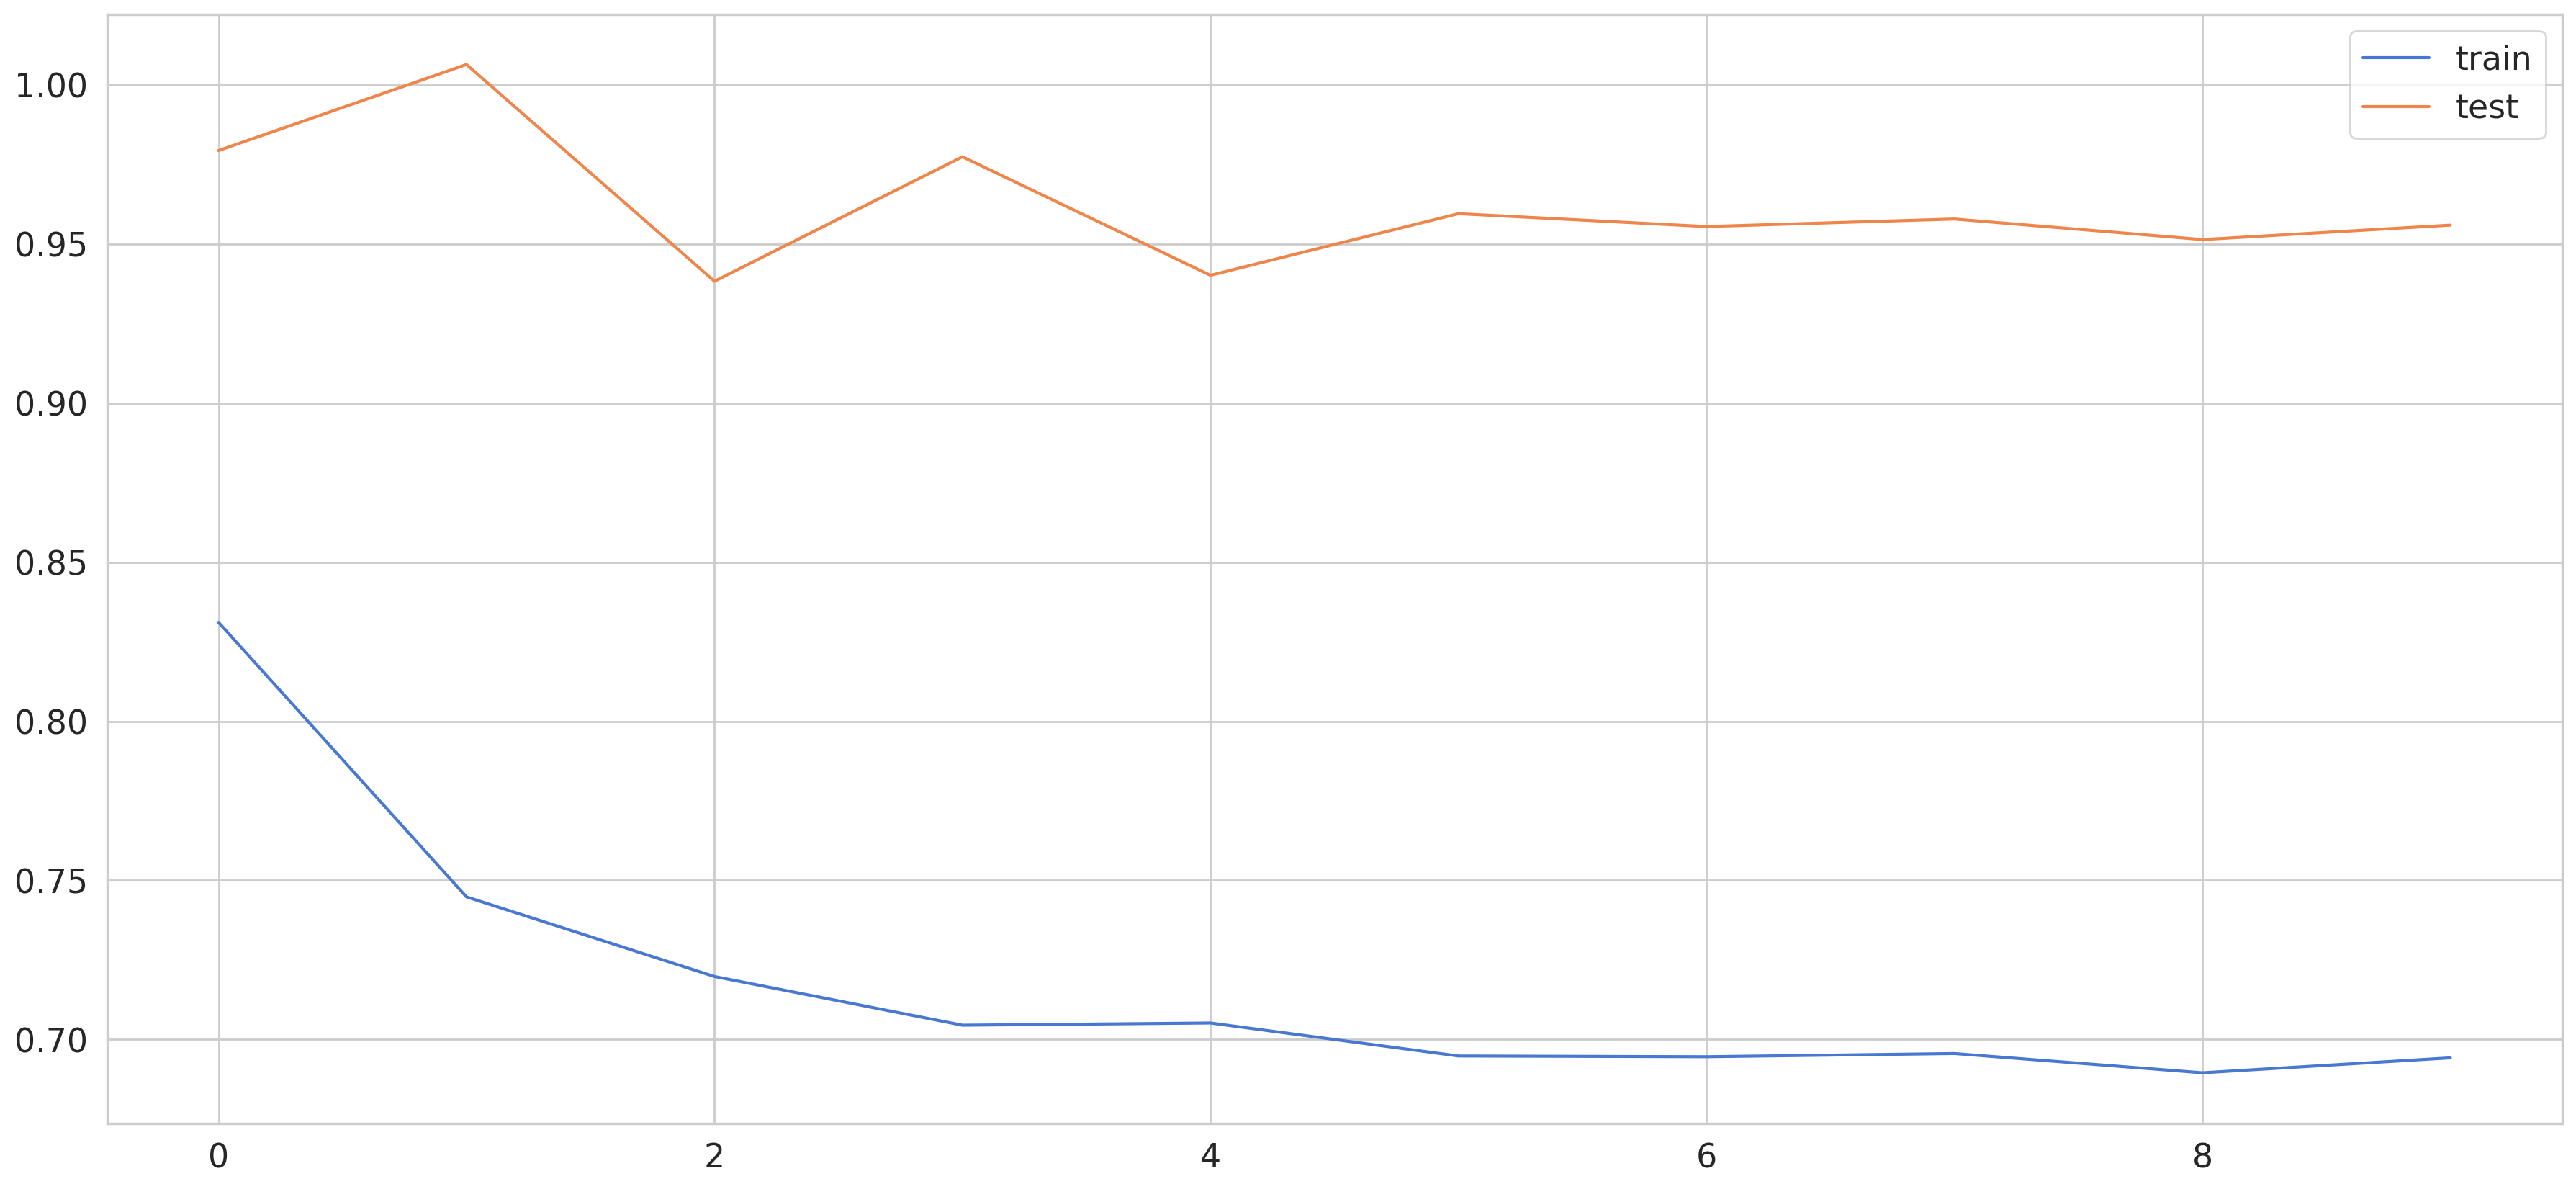

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

CALC LOSS BETWEEN yPred - yTest

In [19]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

39/39 [==============================] - 5s 64ms/step


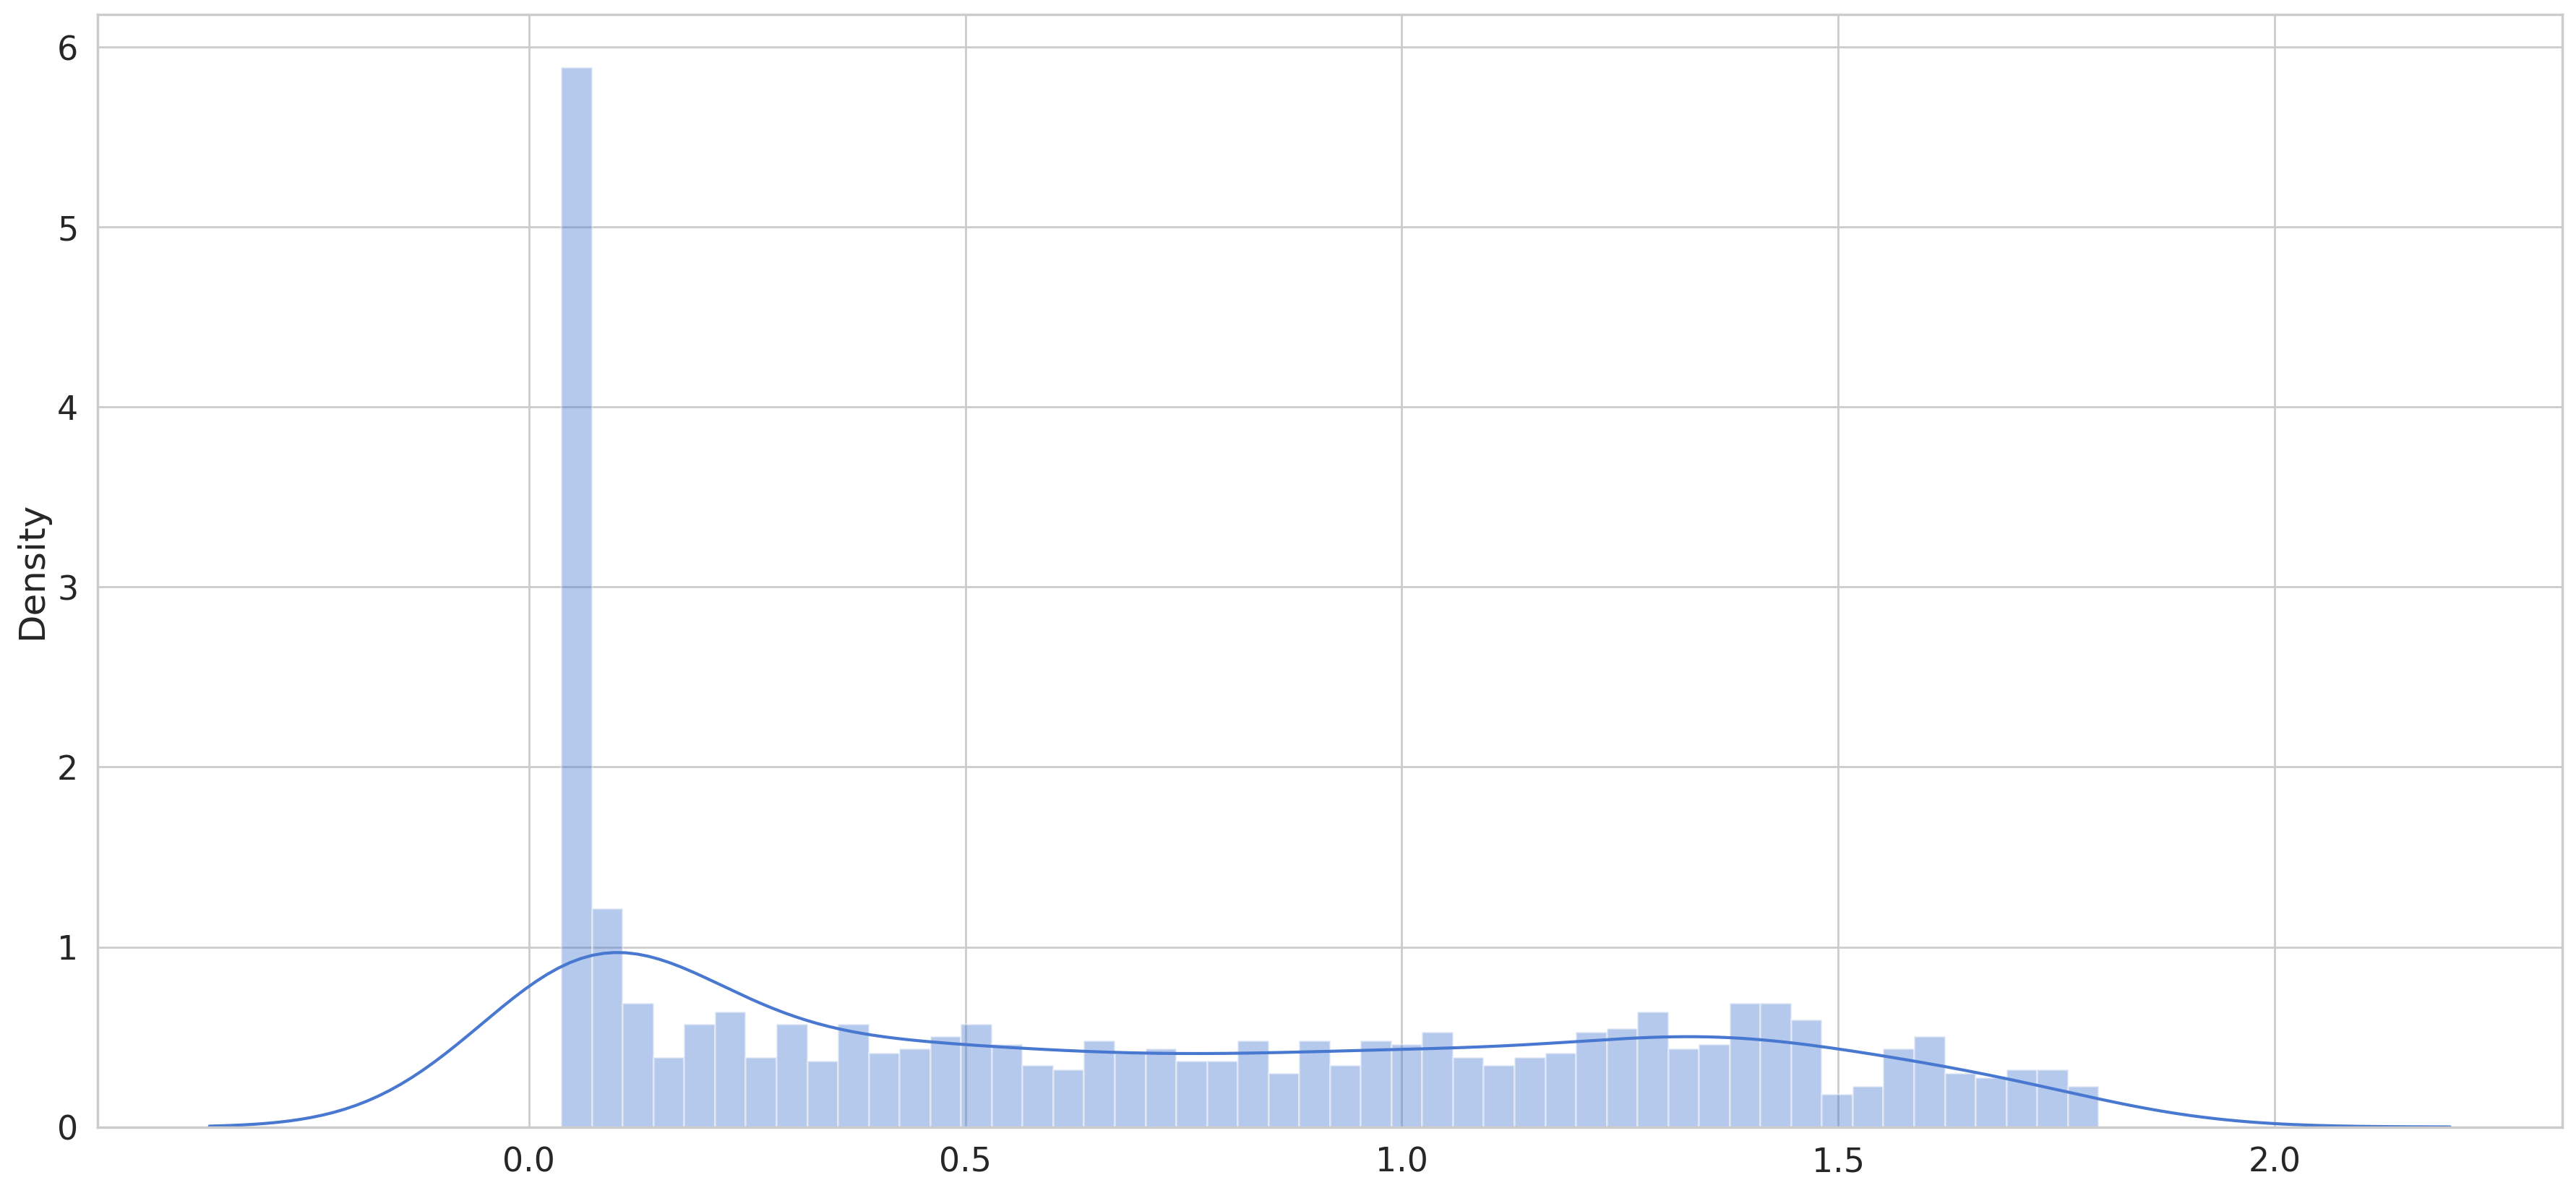

In [20]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [21]:

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

2/2 [==============================] - 0s 13ms/step


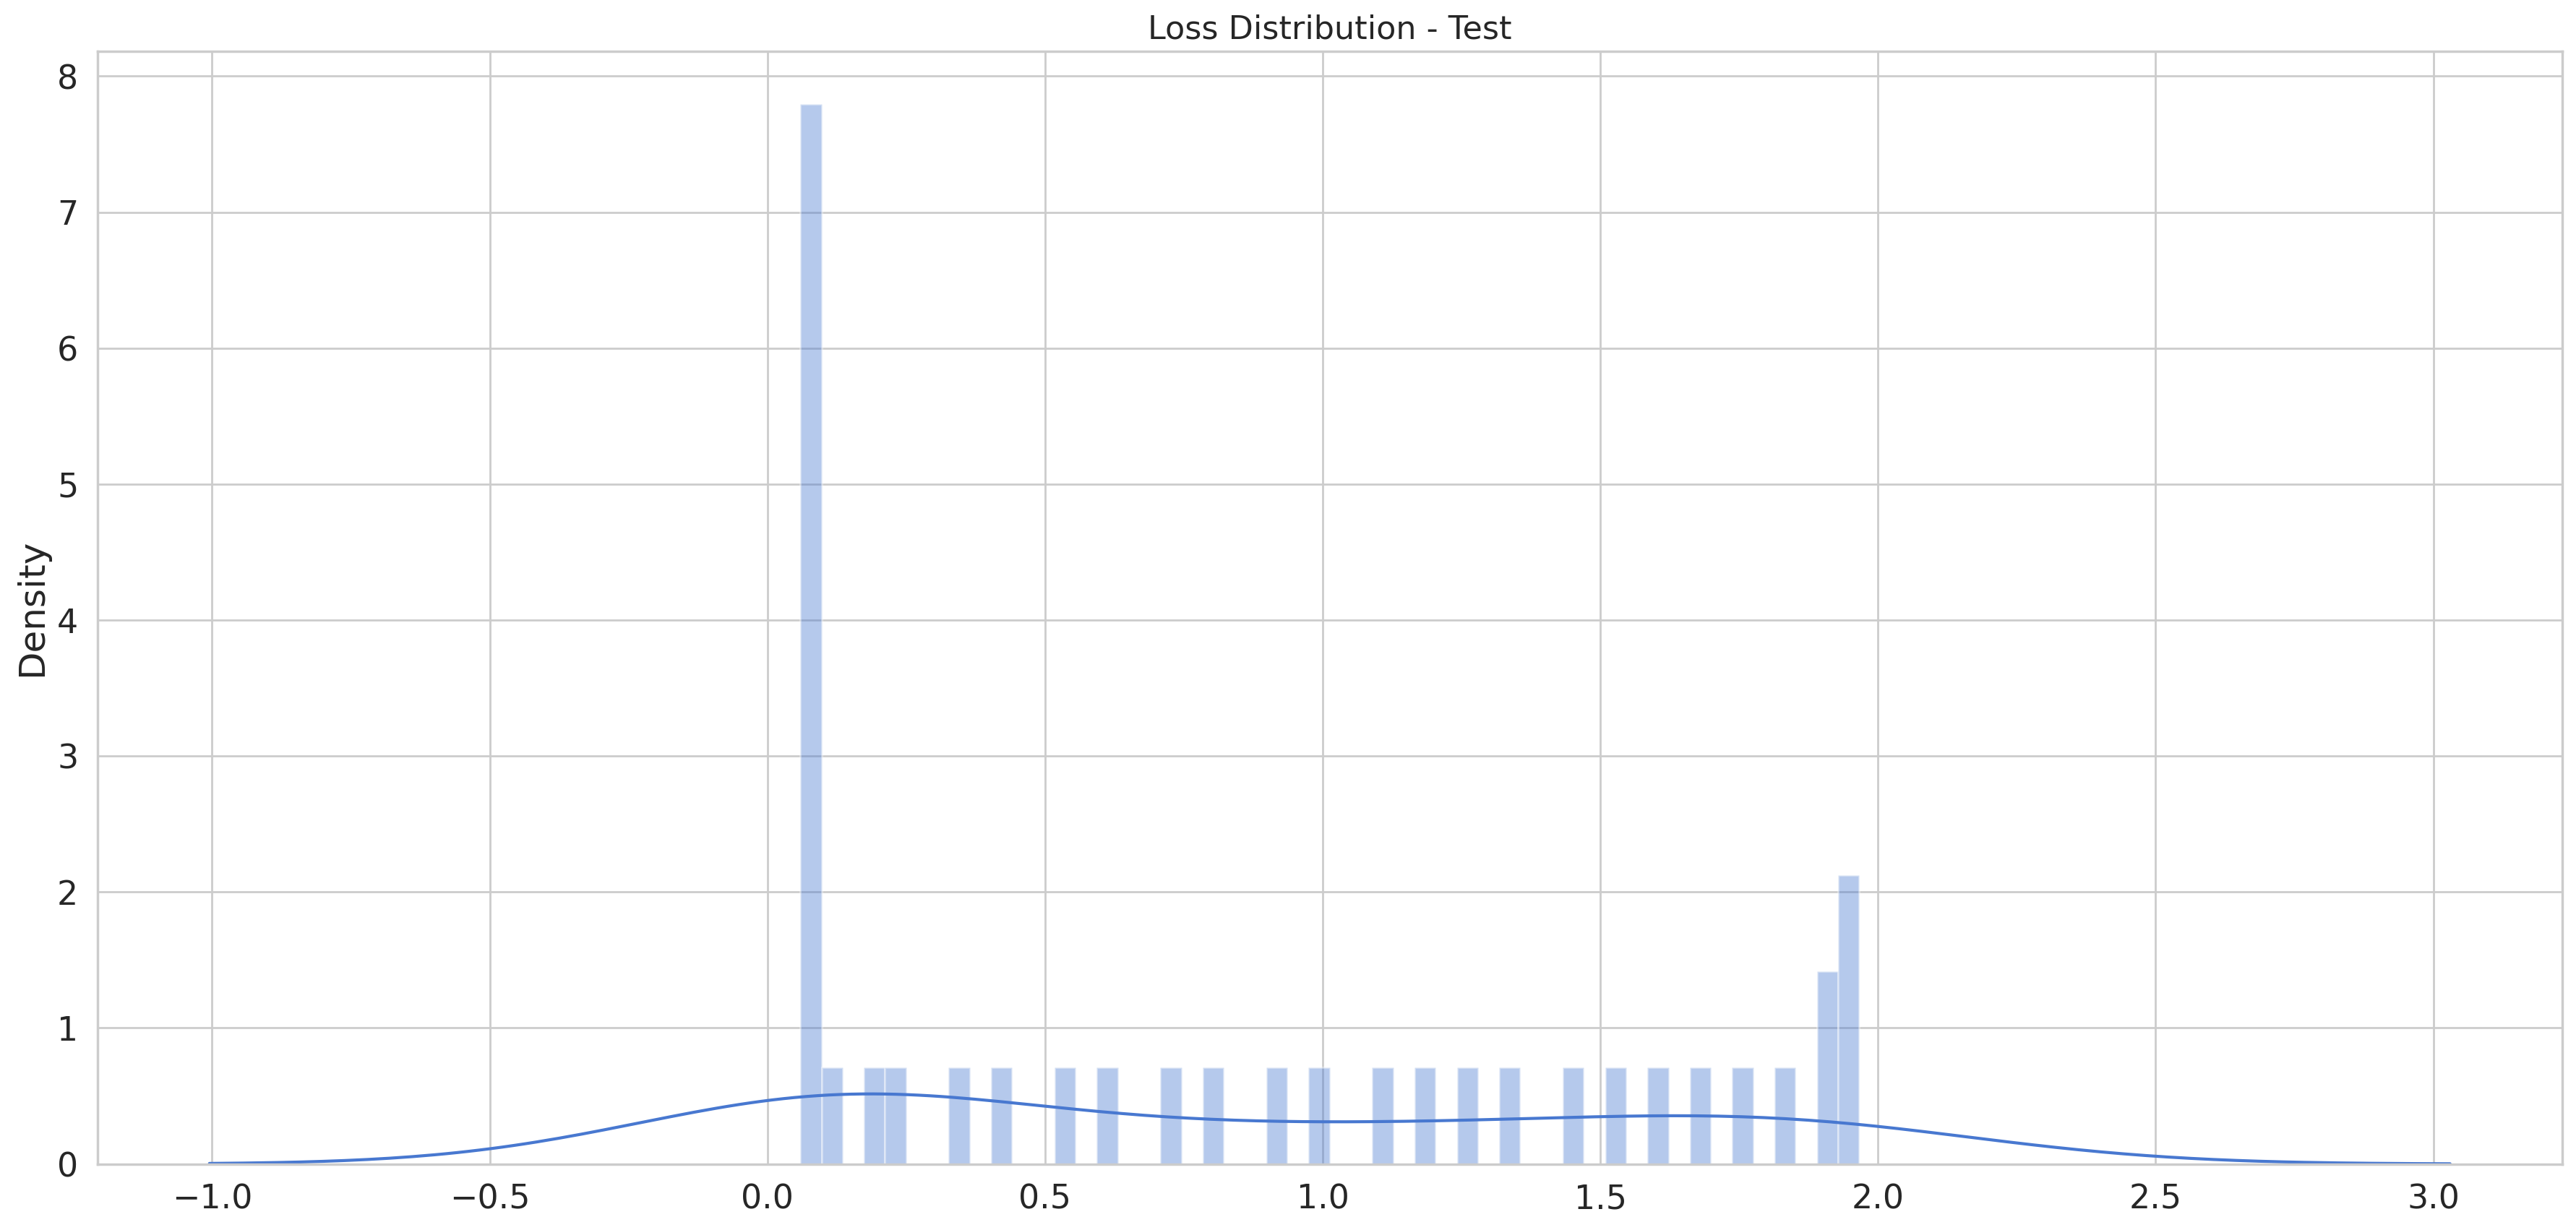

In [22]:
plt.title('Loss Distribution - Test', fontsize=16)
sns.distplot(test_mae_loss, bins=50, kde=True);

CALC THRESHOLD WITH STD.DEVAITION

In [23]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

# Compute threshold dynamically
mean_loss = np.mean(test_mae_loss)
std_loss = np.std(test_mae_loss)
THRESHOLD = mean_loss + 2 * std_loss  # Adjust the multiplier as needed

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Iavg_A'] = test[TIME_STEPS:].Iavg_A


2/2 [==============================] - 0s 15ms/step


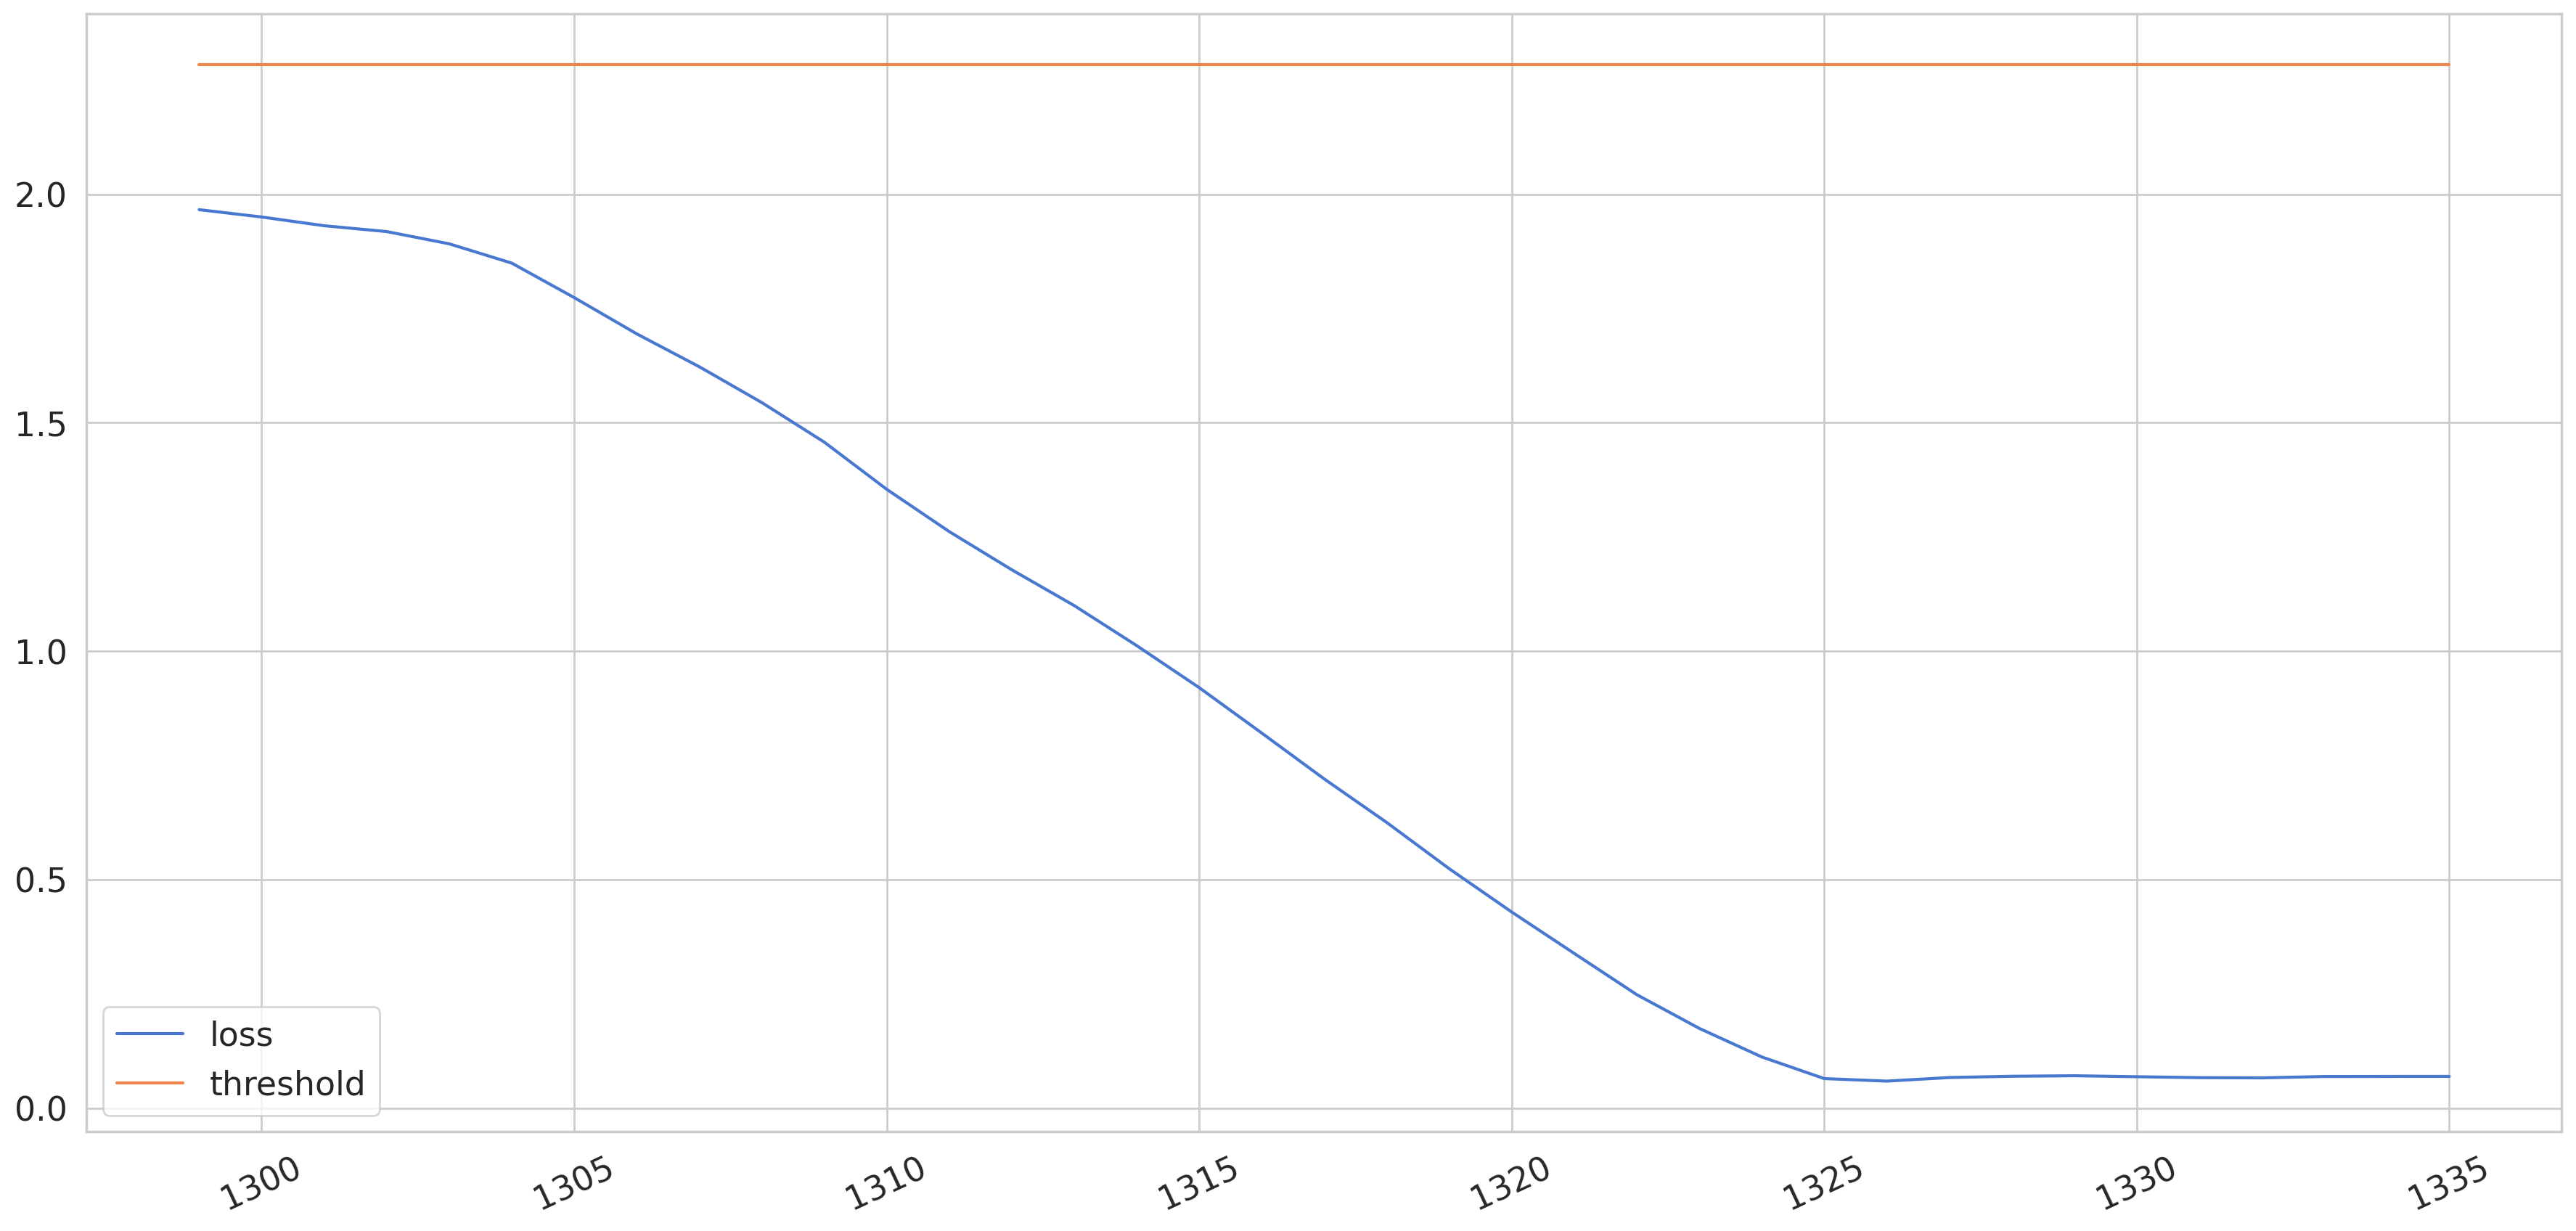

In [24]:

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();


In [25]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()
# len(anomalies)

,loss,threshold,anomaly,Iavg_A


In [26]:
test

,Time,Iavg_A
1269,2021-01-29 05:30:00,-0.639777
1270,2021-01-29 06:00:00,-0.512238
1271,2021-01-29 06:30:00,-0.280376
1272,2021-01-29 07:00:00,0.266346
1273,2021-01-29 07:30:00,0.702408
...,...,...
1331,2021-01-30 12:30:00,-0.568939
1332,2021-01-30 13:00:00,-0.564144
1333,2021-01-30 13:30:00,-0.555427
1334,2021-01-30 14:00:00,-0.546167


In [27]:
test_score_df

,loss,threshold,anomaly,Iavg_A
1299,1.966078,2.282759,False,-0.613755
1300,1.950059,2.282759,False,-0.604772
1301,1.930956,2.282759,False,-0.607252
1302,1.918163,2.282759,False,-0.511481
1303,1.891407,2.282759,False,-0.579356
1304,1.849233,2.282759,False,-0.586425
1305,1.773732,2.282759,False,-0.587263
1306,1.694455,2.282759,False,-0.577208
1307,1.622516,2.282759,False,-0.575262
1308,1.544149,2.282759,False,-0.579350


In [28]:
merged_df = test.merge(test_score_df, left_index=True, right_index=True)
merged_df

,Time,Iavg_A_x,loss,threshold,anomaly,Iavg_A_y
1299,2021-01-29 20:30:00,-0.613755,1.966078,2.282759,False,-0.613755
1300,2021-01-29 21:00:00,-0.604772,1.950059,2.282759,False,-0.604772
1301,2021-01-29 21:30:00,-0.607252,1.930956,2.282759,False,-0.607252
1302,2021-01-29 22:00:00,-0.511481,1.918163,2.282759,False,-0.511481
1303,2021-01-29 22:30:00,-0.579356,1.891407,2.282759,False,-0.579356
1304,2021-01-29 23:00:00,-0.586425,1.849233,2.282759,False,-0.586425
1305,2021-01-29 23:30:00,-0.587263,1.773732,2.282759,False,-0.587263
1306,2021-01-30 00:00:00,-0.577208,1.694455,2.282759,False,-0.577208
1307,2021-01-30 00:30:00,-0.575262,1.622516,2.282759,False,-0.575262
1308,2021-01-30 01:00:00,-0.579350,1.544149,2.282759,False,-0.579350


In [29]:
merged_df

,Time,Iavg_A_x,loss,threshold,anomaly,Iavg_A_y
1299,2021-01-29 20:30:00,-0.613755,1.966078,2.282759,False,-0.613755
1300,2021-01-29 21:00:00,-0.604772,1.950059,2.282759,False,-0.604772
1301,2021-01-29 21:30:00,-0.607252,1.930956,2.282759,False,-0.607252
1302,2021-01-29 22:00:00,-0.511481,1.918163,2.282759,False,-0.511481
1303,2021-01-29 22:30:00,-0.579356,1.891407,2.282759,False,-0.579356
1304,2021-01-29 23:00:00,-0.586425,1.849233,2.282759,False,-0.586425
1305,2021-01-29 23:30:00,-0.587263,1.773732,2.282759,False,-0.587263
1306,2021-01-30 00:00:00,-0.577208,1.694455,2.282759,False,-0.577208
1307,2021-01-30 00:30:00,-0.575262,1.622516,2.282759,False,-0.575262
1308,2021-01-30 01:00:00,-0.579350,1.544149,2.282759,False,-0.579350


In [30]:
import plotly.express as px

def plot_anomaly_scatter(df):
    fig = px.scatter(df.reset_index(), x='Time', y='Iavg_A_y', color='anomaly', title='Iavg_A')

    fig.update_xaxes(
        rangeslider_visible=True,
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(count=2, label="2y", step="year", stepmode="backward"),
                dict(count=3, label="3y", step="year", stepmode="backward"),
                dict(step='all')
            ])
        )
    )
    
    fig.show()


plot_anomaly_scatter(merged_df)

No scaling

In [31]:
train_size = int(len(dfIavg_A_30T) * 0.95)
test_size = len(dfIavg_A_30T) - train_size
train, test = dfIavg_A_30T.iloc[0:train_size], dfIavg_A_30T.iloc[train_size:len(dfIavg_A_30T)]
print(train.shape, test.shape)



def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Iavg_A']], train.Iavg_A, TIME_STEPS)
X_test, y_test = create_dataset(test[['Iavg_A']], test.Iavg_A, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(1269, 2) (67, 2)
(1239, 30, 1)
Epoch 1/10
6/6 [==============================] - 8s 473ms/step - loss: 25.1395 - val_loss: 27.9648
Epoch 2/10
6/6 [==============================] - 2s 277ms/step - loss: 20.1770 - val_loss: 23.7494
Epoch 3/10
6/6 [==============================] - 2s 310ms/step - loss: 16.1858 - val_loss: 20.3348
Epoch 4/10
6/6 [==============================] - 3s 513ms/step - loss: 13.3840 - val_loss: 18.2882
Epoch 5/10
6/6 [==============================] - 2s 345ms/step - loss: 12.3592 - val_loss: 17.1644
Epoch 6/10
6/6 [==============================] - 2s 298ms/step - loss: 12.1772 - val_loss: 16.7519
Epoch 7/10
6/6 [==============================] - 2s 276ms/step - loss: 12.1651 - val_loss: 16.6397
Epoch 8/10
6/6 [==============================] - 2s 277ms/step - loss: 12.1620 - val_loss: 16.6067
Epoch 9/10
6/6 [==============================] - 2s 281ms/step - loss: 12.1542 - val_loss: 16.6068
Epoch 10/10
6/6 [==============================] - 2s 274ms/step - l

MinMax Scaler

In [32]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train[['Iavg_A']])
train['Iavg_A'] = scaler.transform(train[['Iavg_A']])
test['Iavg_A'] = scaler.transform(test[['Iavg_A']])
from sklearn.preprocessing import MinMaxScaler

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(train[['Iavg_A']])

# Scale the training and testing data
train['Iavg_A'] = scaler.transform(train[['Iavg_A']])
test['Iavg_A'] = scaler.transform(test[['Iavg_A']])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Iavg_A']], train.Iavg_A, TIME_STEPS)
X_test, y_test = create_dataset(test[['Iavg_A']], test.Iavg_A, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(1239, 30, 1)
Epoch 1/10
6/6 [==============================] - 8s 461ms/step - loss: 0.2312 - val_loss: 0.2582
Epoch 2/10
6/6 [==============================] - 2s 282ms/step - loss: 0.1932 - val_loss: 0.2507
Epoch 3/10
6/6 [==============================] - 2s 290ms/step - loss: 0.1826 - val_loss: 0.2415
Epoch 4/10
6/6 [==============================] - 2s 286ms/step - loss: 0.1777 - val_loss: 0.2483
Epoch 5/10
6/6 [==============================] - 3s 457ms/step - loss: 0.1771 - val_loss: 0.2393
Epoch 6/10
6/6 [==============================] - 3s 480ms/step - loss: 0.1759 - val_loss: 0.2489
Epoch 7/10
6/6 [==============================] - 2s 307ms/step - loss: 0.1754 - val_loss: 0.2410
Epoch 8/10
6/6 [==============================] - 2s 299ms/step - loss: 0.1748 - val_loss: 0.2443
Epoch 9/10
6/6 [==============================] - 2s 288ms/step - loss: 0.1746 - val_loss: 0.2431
Epoch 10/10
6/6 [==============================] - 2s 287ms/step - loss: 0.1745 - val_loss: 0.2427


Gradient Clipping, Regularization Batvh Normalization

If you are encountering a loss of nan (Not a Number) during the training of your model, it typically indicates numerical instability or exploding/vanishing gradients. Here are a few steps you can take to address this issue:

* **Check your data**: Make sure your input data does not contain missing values or outliers that could lead to numerical instability. You can perform data preprocessing steps such as data normalization or imputation of missing values to improve the quality of your input data.

* **Adjust learning rate:** An excessively high learning rate can cause the loss to diverge or result in unstable training. Try reducing the learning rate to a smaller value to stabilize the training process. Alternatively, you can use adaptive learning rate techniques, such as learning rate schedules or optimizers like Adam, which automatically adjust the learning rate based on the training progress.

* **Gradient clipping**: If you're using gradient-based optimization algorithms, gradient clipping can help mitigate exploding gradients. By setting a threshold, you can limit the maximum gradient value during the training process. This can be achieved by using the clipvalue or clipnorm parameters in your optimizer.

* **Regularization**: Applying regularization techniques like L1 or L2 regularization (weight decay) can help prevent overfitting and improve numerical stability. Regularization adds a penalty term to the loss function, discouraging large weights and reducing the chances of divergence.

* **Batch normalization**: Implementing batch normalization layers in your model can help stabilize the training process and mitigate the effect of vanishing/exploding gradients. Batch normalization normalizes the input to each layer by adjusting the mean and standard deviation, which can prevent the gradients from becoming too large or too small.

* **Model architecture**: Consider modifying the architecture of your model. You can try reducing the complexity of the model by reducing the number of layers or the number of units in each layer. A simpler model may be more stable during training.

* **Increase training data**: Insufficient training data can sometimes lead to numerical instability. If you have a small dataset, consider augmenting it or obtaining more training samples to improve the generalization and stability of your model.

By implementing these steps, you should be able to address the issue of a loss value of nan during the training of your model. It's also important to monitor the training process closely and experiment with different approaches to find the best combination of techniques for your specific problem.

Standard Scaler

In [33]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

train_size = int(len(dfIavg_A_30T) * 0.95)
test_size = len(dfIavg_A_30T) - train_size
train, test = dfIavg_A_30T.iloc[0:train_size], dfIavg_A_30T.iloc[train_size:len(dfIavg_A_30T)]
print(train.shape, test.shape)


scaler = StandardScaler()
scaler = scaler.fit(train[['Iavg_A']])

train['Iavg_A'] = scaler.transform(train[['Iavg_A']])
test['Iavg_A'] = scaler.transform(test[['Iavg_A']])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['Iavg_A']], train.Iavg_A, TIME_STEPS)
X_test, y_test = create_dataset(test[['Iavg_A']], test.Iavg_A, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2]),
    kernel_regularizer=regularizers.l2(0.01),
    recurrent_regularizer=regularizers.l2(0.01),
    bias_regularizer=regularizers.l2(0.01),
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(
    units=64,
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01),
    recurrent_regularizer=regularizers.l2(0.01),
    bias_regularizer=regularizers.l2(0.01),
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)],
)


(1269, 2) (67, 2)
(1239, 30, 1)
Epoch 1/10
6/6 [==============================] - 8s 455ms/step - loss: 4.5385 - val_loss: 4.3500
Epoch 2/10
6/6 [==============================] - 2s 278ms/step - loss: 4.2316 - val_loss: 4.1109
Epoch 3/10
6/6 [==============================] - 2s 252ms/step - loss: 3.9760 - val_loss: 3.8854
Epoch 4/10
6/6 [==============================] - 1s 151ms/step - loss: 3.7456 - val_loss: 3.6793
Epoch 5/10
6/6 [==============================] - 1s 145ms/step - loss: 3.5375 - val_loss: 3.4924
Epoch 6/10
6/6 [==============================] - 1s 145ms/step - loss: 3.3499 - val_loss: 3.3235
Epoch 7/10
6/6 [==============================] - 1s 147ms/step - loss: 3.1800 - val_loss: 3.1723
Epoch 8/10
6/6 [==============================] - 1s 153ms/step - loss: 3.0267 - val_loss: 3.0368
Epoch 9/10
6/6 [==============================] - 1s 150ms/step - loss: 2.8895 - val_loss: 2.9159
Epoch 10/10
6/6 [==============================] - 1s 147ms/step - loss: 2.7676 - val_

No Scaling

In [34]:
train_size = int(len(dfIavg_A_30T) * 0.95)
test_size = len(dfIavg_A_30T) - train_size
train, test = dfIavg_A_30T.iloc[0:train_size], dfIavg_A_30T.iloc[train_size:len(dfIavg_A_30T)]
print(train.shape, test.shape)



def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Iavg_A']], train.Iavg_A, TIME_STEPS)
X_test, y_test = create_dataset(test[['Iavg_A']], test.Iavg_A, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(1269, 2) (67, 2)
(1239, 30, 1)
Epoch 1/10
6/6 [==============================] - 7s 339ms/step - loss: 26.8096 - val_loss: 31.7153
Epoch 2/10
6/6 [==============================] - 2s 256ms/step - loss: 24.8687 - val_loss: 29.6103
Epoch 3/10
6/6 [==============================] - 2s 257ms/step - loss: 22.7706 - val_loss: 27.7788
Epoch 4/10
6/6 [==============================] - 1s 253ms/step - loss: 20.9973 - val_loss: 26.2174
Epoch 5/10
6/6 [==============================] - 1s 150ms/step - loss: 19.5010 - val_loss: 24.8720
Epoch 6/10
6/6 [==============================] - 1s 145ms/step - loss: 18.2598 - val_loss: 23.7804
Epoch 7/10
6/6 [==============================] - 1s 149ms/step - loss: 17.2566 - val_loss: 22.9000
Epoch 8/10
6/6 [==============================] - 1s 148ms/step - loss: 16.4500 - val_loss: 22.1636
Epoch 9/10
6/6 [==============================] - 1s 142ms/step - loss: 15.7493 - val_loss: 21.5125
Epoch 10/10
6/6 [==============================] - 1s 142ms/step - l

MinMax Scalar

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['Iavg_A']])
train['Iavg_A'] = scaler.transform(train[['Iavg_A']])
test['Iavg_A'] = scaler.transform(test[['Iavg_A']])
from sklearn.preprocessing import MinMaxScaler

# Initialize and fit the scaler
scaler = MinMaxScaler()
scaler.fit(train[['Iavg_A']])

# Scale the training and testing data
train['Iavg_A'] = scaler.transform(train[['Iavg_A']])
test['Iavg_A'] = scaler.transform(test[['Iavg_A']])

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# Create the training and testing datasets without scaling
X_train, y_train = create_dataset(train[['Iavg_A']], train.Iavg_A, TIME_STEPS)
X_test, y_test = create_dataset(test[['Iavg_A']], test.Iavg_A, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(1239, 30, 1)
Epoch 1/10
6/6 [==============================] - 6s 319ms/step - loss: 0.2442 - val_loss: 0.2601
Epoch 2/10
6/6 [==============================] - 1s 139ms/step - loss: 0.2054 - val_loss: 0.2517
Epoch 3/10
6/6 [==============================] - 1s 144ms/step - loss: 0.1887 - val_loss: 0.2556
Epoch 4/10
6/6 [==============================] - 1s 230ms/step - loss: 0.1852 - val_loss: 0.2447
Epoch 5/10
6/6 [==============================] - 2s 258ms/step - loss: 0.1815 - val_loss: 0.2418
Epoch 6/10
6/6 [==============================] - 1s 239ms/step - loss: 0.1791 - val_loss: 0.2437
Epoch 7/10
6/6 [==============================] - 1s 182ms/step - loss: 0.1774 - val_loss: 0.2451
Epoch 8/10
6/6 [==============================] - 1s 136ms/step - loss: 0.1765 - val_loss: 0.2405
Epoch 9/10
6/6 [==============================] - 1s 141ms/step - loss: 0.1762 - val_loss: 0.2416
Epoch 10/10
6/6 [==============================] - 1s 142ms/step - loss: 0.1756 - val_loss: 0.2434


Optimizer Function

In [36]:
from sklearn.preprocessing import StandardScaler

train_size = int(len(dfIavg_A_30T) * 0.95)
test_size = len(dfIavg_A_30T) - train_size
train, test = dfIavg_A_30T.iloc[0:train_size], dfIavg_A_30T.iloc[train_size:len(dfIavg_A_30T)]
print(train.shape, test.shape)


scaler = StandardScaler()
scaler = scaler.fit(train[['Iavg_A']])

train['Iavg_A'] = scaler.transform(train[['Iavg_A']])
test['Iavg_A'] = scaler.transform(test[['Iavg_A']])
     
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['Iavg_A']], train.Iavg_A, TIME_STEPS)
X_test, y_test = create_dataset(test[['Iavg_A']], test.Iavg_A, TIME_STEPS)

print(X_train.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=128,  # Reduce the number of units
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=128, return_sequences=True))  # Reduce the number of units
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.001))  # Reduce the learning rate

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.1,
    shuffle=False
)


(1269, 2) (67, 2)
(1239, 30, 1)
Epoch 1/10
6/6 [==============================] - 8s 472ms/step - loss: 0.8347 - val_loss: 0.9776
Epoch 2/10
6/6 [==============================] - 2s 280ms/step - loss: 0.7382 - val_loss: 1.0195
Epoch 3/10
6/6 [==============================] - 3s 480ms/step - loss: 0.7195 - val_loss: 0.9390
Epoch 4/10
6/6 [==============================] - 3s 438ms/step - loss: 0.7076 - val_loss: 0.9966
Epoch 5/10
6/6 [==============================] - 2s 286ms/step - loss: 0.7018 - val_loss: 0.9544
Epoch 6/10
6/6 [==============================] - 2s 294ms/step - loss: 0.6955 - val_loss: 0.9428
Epoch 7/10
6/6 [==============================] - 2s 291ms/step - loss: 0.6936 - val_loss: 0.9727
Epoch 8/10
6/6 [==============================] - 2s 286ms/step - loss: 0.6934 - val_loss: 0.9506
Epoch 9/10
6/6 [==============================] - 2s 291ms/step - loss: 0.6902 - val_loss: 0.9635
Epoch 10/10
6/6 [==============================] - 2s 383ms/step - loss: 0.6916 - val_